# Example using scikit-learn: Feature correlation and feature reduction, Logistic Regression  vs Gradient Boosting model comparison

## Methodology

The following data science steps will be demonstrated:

1. Univariate feature reduction (remove low correlations with the target).
2. Paired feature reduction (for each highly correlated pair, use only the feature that correlates better with the target).
3. Compare two different model types (Logistic Regression and GBM), including the testing and ranking of feature importance.
4. Calculate percentile bins for each model in order to analyze the ratio of positive classes for each percentile bin.
5. Plot ROC and Precision curves.

## Data

The tagged data set is from the "Breast Cancer Wisconsin (Diagnostic) Database" freely available in python's sklearn library.  

* Number of Samples: 569  
* Number of Features: 30 numeric, predictive attributes  
* Number of Classes: 2 

The two target classes correspond to negative outcomes (Benign) and positive outcomes (Malignant).

This original data set will be randomly split into two sets for train and test purposes.

## Pre-processing

In [0]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict

from sklearn import datasets
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

DISPLAY_PRECISION = 4
pd.set_option("display.precision", DISPLAY_PRECISION)

## Get the breast cancer dataset from sklearn

In [0]:
dat = datasets.load_breast_cancer()
# print(dat.DESCR)  # detailed description

## Describe the feature statistics

In [25]:
print("The sklearn breast cancer dataset keys:")
print(dat.keys()) # dict_keys(['target_names', 'target', 'feature_names', 'data', 'DESCR'])
print("---")

# Note that we need to reverse the original '0' and '1' mapping in order to end up with this mapping:
# Benign = 0 (negative class)
# Malignant = 1 (positive class)

li_classes = [dat.target_names[1], dat.target_names[0]]
li_target = [1 if x==0 else 0 for x in list(dat.target)]

li_ftrs = list(dat.feature_names)

print("There are 2 target classes:")
print("li_classes", li_classes)
print("---")
print("Target class distribution from a total of %d target values:" % len(li_target))
print(pd.Series(li_target).value_counts())
print("---")

df_all = pd.DataFrame(dat.data[:,:], columns=li_ftrs)
print("Describe dataframe, first 6 columns:")
print(df_all.iloc[:,:6].describe().to_string())

The sklearn breast cancer dataset keys:
dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])
---
There are 2 target classes:
li_classes ['benign', 'malignant']
---
Target class distribution from a total of 569 target values:
0    357
1    212
dtype: int64
---
Describe dataframe, first 6 columns:
       mean radius  mean texture  mean perimeter  mean area  mean smoothness  mean compactness
count     569.0000      569.0000         569.000   569.0000         569.0000          569.0000
mean       14.1273       19.2896          91.969   654.8891           0.0964            0.1043
std         3.5240        4.3010          24.299   351.9141           0.0141            0.0528
min         6.9810        9.7100          43.790   143.5000           0.0526            0.0194
25%        11.7000       16.1700          75.170   420.3000           0.0864            0.0649
50%        13.3700       18.8400          86.240   551.1000           0.0959            0.0926
75%        15.7800 

## Split the data into train and test sets

In [26]:
TEST_SIZE_RATIO = 0.5

# Setup X and y
X = df_all
y = pd.Series(li_target)

X_train_0, X_test_0, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_RATIO, random_state=0)
print("X_train_0.shape, y_train.shape", X_train_0.shape, y_train.shape)
print("X_test_0.shape, y_test.shape", X_test_0.shape, y_test.shape)

X_train_0.shape, y_train.shape (284, 30) (284,)
X_test_0.shape, y_test.shape (285, 30) (285,)


## Feature reduction
There are many other popular methods for feature reduction such as RFE (Recursive Feature Elimination) and PCA (Principal Component Analysis), each with its own advantages and disadvantages.

The feature selection demonstrated below is for two other popular techniques:

1. Univariate feature reduction (remove low correlations with the target).
2. Paired feature reduction (for each highly correlated pair, use only the feature that correlates better with the target).

## Create a correlation heatmap of absolute correlation scores

Function correlation_matrix: X.shape, y.shape, yX.shape: (284, 30) (284,) (284, 31)



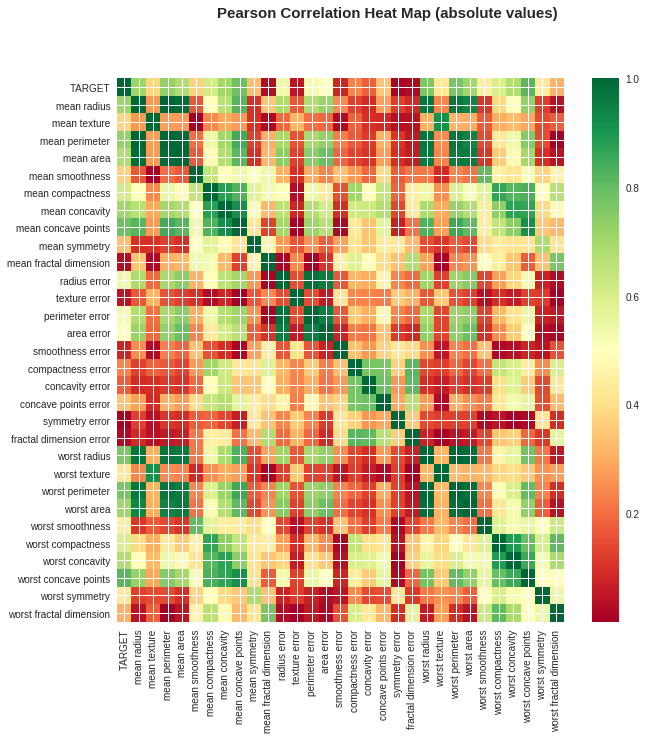

In [27]:
def correlation_matrix(y, X, is_plot=False):
  # Calculate and plot the correlation symmetrical matrix
  # Return:
  # yX - concatenated data
  # yX_corr - correlation matrix, pearson correlation of values from -1 to +1
  # yX_abs_corr - correlation matrix, absolute values
  
  yX = pd.concat([y, X], axis=1)
  yX = yX.rename(columns={0: 'TARGET'})  # rename first column

  print("Function correlation_matrix: X.shape, y.shape, yX.shape:", X.shape, y.shape, yX.shape)
  print()

  # Get feature correlations and transform to dataframe
  yX_corr = yX.corr(method='pearson')

  # Convert to abolute values
  yX_abs_corr = np.abs(yX_corr) 
  
  if is_plot:
    plt.figure(figsize=(10, 10))
    plt.imshow(yX_abs_corr, cmap='RdYlGn', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(yX_abs_corr)), yX_abs_corr.columns, rotation='vertical')
    plt.yticks(range(len(yX_abs_corr)), yX_abs_corr.columns);
    plt.suptitle('Pearson Correlation Heat Map (absolute values)', fontsize=15, fontweight='bold')
    plt.show()
  
  return yX, yX_corr, yX_abs_corr

# Build the correlation matrix for the train data
yX, yX_corr, yX_abs_corr = correlation_matrix(y_train, X_train_0, is_plot=True)  

**Note the high correlation values between features which are transformation of one another e.g. mean radius, mean perimeter, mean area, worst radius, worst perimeter, worst area.**

##  Univariate feature reduction, remove features that are poorly correlated with the target



In [28]:
CORRELATION_MIN = 0.1

# Note that this is calculated as preparation for the next step
s_corr_target = yX_abs_corr['TARGET']
s_corr_target_sort = s_corr_target.sort_values(ascending=False)

# Only use features with a minimum pearson correlation with the target of 0.1
s_low_correlation_ftrs = s_corr_target_sort[s_corr_target_sort <= CORRELATION_MIN]

# Print
print("Removed %d low correlation features:" % len(s_low_correlation_ftrs))
for i,v in enumerate(s_low_correlation_ftrs):
  print(i,np.round(v, DISPLAY_PRECISION), s_low_correlation_ftrs.index[i])
  
print("---")

s_corr_target_sort = s_corr_target_sort[s_corr_target_sort > CORRELATION_MIN]

print("Remaining %d feature correlations:" % (len(s_corr_target_sort)-1))
for i,v in enumerate(s_corr_target_sort):
  ftr = s_corr_target_sort.index[i]
  if ftr == 'TARGET':
    continue
    
  print(i,np.round(v, DISPLAY_PRECISION), ftr)

Removed 5 low correlation features:
0 0.0811 smoothness error
1 0.0449 texture error
2 0.0297 mean fractal dimension
3 0.0262 fractal dimension error
4 0.0087 symmetry error
---
Remaining 25 feature correlations:
1 0.8138 worst concave points
2 0.7817 mean concave points
3 0.766 worst perimeter
4 0.7612 worst radius
5 0.724 mean perimeter
6 0.7108 mean radius
7 0.7065 worst area
8 0.7035 mean concavity
9 0.6796 worst concavity
10 0.679 mean area
11 0.6132 mean compactness
12 0.6007 worst compactness
13 0.537 radius error
14 0.524 perimeter error
15 0.494 area error
16 0.448 worst smoothness
17 0.4363 worst symmetry
18 0.429 worst texture
19 0.38 mean texture
20 0.3719 mean smoothness
21 0.3458 concave points error
22 0.3336 mean symmetry
23 0.3116 worst fractal dimension
24 0.2373 compactness error
25 0.1767 concavity error


## Paired feature reduction: find the most correlated feature pairs

In [29]:
CORRELATION_MAX = 0.8

li_X1_cols = list(set(s_corr_target_sort.index) - set(s_low_correlation_ftrs.index)) 
li_X1_cols.remove('TARGET')

# Build the correlation matrix for the reduced X
X1 = X_train_0[li_X1_cols]
yX1, yX_corr1, yX_abs_corr1 = correlation_matrix(y_train, X1, is_plot=False)  

# Get all the feature pairs
Xcorr1 = yX_abs_corr1.iloc[1:,1:]
s_pairs = Xcorr1.unstack()
print("s_pairs.shape", s_pairs.shape)
s_pairs = np.round(s_pairs, decimals=DISPLAY_PRECISION)

# Sort all the pairs by highest correlation scores
s_pairs_sorted = s_pairs.sort_values(ascending=False) 
s_pairs_sorted = s_pairs_sorted[(s_pairs_sorted != 1) & (s_pairs_sorted > CORRELATION_MAX)]  # leave only the top matches that are not identical features

# Convert to a list of name tuples e.g. ('mean radius', 'mean perimeter')
li_corr_pairs = s_pairs_sorted.index.tolist()

print("len(li_corr_pairs):", len(li_corr_pairs))
print("li_corr_pairs[:10]", li_corr_pairs[:10])

Function correlation_matrix: X.shape, y.shape, yX.shape: (284, 25) (284,) (284, 26)

s_pairs.shape (625,)
len(li_corr_pairs): 78
li_corr_pairs[:10] [('mean perimeter', 'mean radius'), ('mean radius', 'mean perimeter'), ('worst perimeter', 'worst radius'), ('worst radius', 'worst perimeter'), ('mean radius', 'mean area'), ('mean area', 'mean radius'), ('mean area', 'mean perimeter'), ('mean perimeter', 'mean area'), ('worst radius', 'worst area'), ('worst area', 'worst radius')]


## For each of the highest correlated feature pairs, remove the feature that is less correlated with the target


In [30]:
# Built list of features to remove
li_remove_pair_ftrs = []
li_remove_scores = []
for tup in li_corr_pairs:
    s0 = s_corr_target_sort.loc[tup[0]]
    s1 = s_corr_target_sort.loc[tup[1]]
    remove_ftr = tup[1] if s1 < s0 else tup[0]  # add the feature that is less correlated with the target to the remove list
    if remove_ftr not in li_remove_pair_ftrs:
        li_remove_pair_ftrs.append(remove_ftr)
        di = {'ftr_0':tup[0], 'ftr_1':tup[1], 'score_0':s0, 'score_1':s1, 'FEATURE_TO_REMOVE':remove_ftr}
        li_remove_scores.append(OrderedDict(di))
   
df_remove_scores = pd.DataFrame(li_remove_scores)
print("Removing %d features (see last column):" % len(li_remove_pair_ftrs))
print(df_remove_scores.to_string())
print("---")

# Remove the features the were found in the above procedure
li_X2_cols = list(set(li_X1_cols) - set(li_remove_pair_ftrs)) 
li_X2_cols.sort()

print("Remaining %d features:" % (len(li_X2_cols)))
for i,v in enumerate(s_corr_target_sort):
  ftr = s_corr_target_sort.index[i]

  if ftr in li_X2_cols:
    print(i,np.round(v, DISPLAY_PRECISION), ftr)

Removing 16 features (see last column):
                   ftr_0                    ftr_1  score_0  score_1        FEATURE_TO_REMOVE
0         mean perimeter              mean radius   0.7240   0.7108              mean radius
1        worst perimeter             worst radius   0.7660   0.7612             worst radius
2            mean radius                mean area   0.7108   0.6790                mean area
3           worst radius               worst area   0.7612   0.7065               worst area
4        perimeter error             radius error   0.5240   0.5370          perimeter error
5           worst radius           mean perimeter   0.7612   0.7240           mean perimeter
6             area error             radius error   0.4940   0.5370               area error
7    mean concave points           mean concavity   0.7817   0.7035           mean concavity
8   worst concave points      mean concave points   0.8138   0.7817      mean concave points
9          worst texture      

**Note above that for the feature reduction, features that have similar predictive power are removed e.g.  mean radius vs mean perimeter. **

## Plot the correlation matrix for the final dataframe columns

After the pair feature reduction, X2.shape: (284, 9)
Function correlation_matrix: X.shape, y.shape, yX.shape: (284, 9) (284,) (284, 10)

Remaining features:
TARGET                  1.0000
worst concave points    0.8138
radius error            0.5370
worst smoothness        0.4480
worst symmetry          0.4363
worst texture           0.4290
concave points error    0.3458
mean symmetry           0.3336
compactness error       0.2373
concavity error         0.1767
Name: TARGET, dtype: float64
---
After the pair feature reduction, X2.shape: (284, 9)
Function correlation_matrix: X.shape, y.shape, yX.shape: (284, 9) (284,) (284, 10)



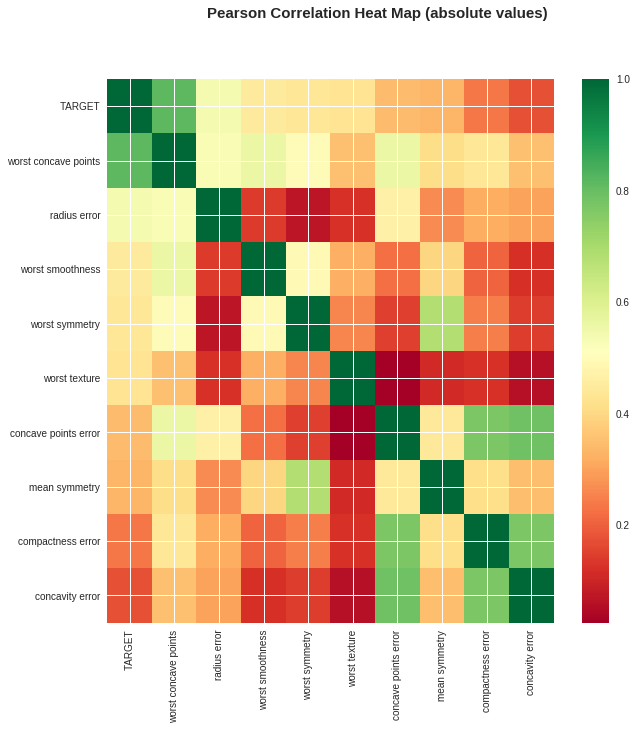

In [31]:
# Calculate correlation matrix on the subset of features
X2 = X1[li_X2_cols]
print("After the pair feature reduction, X2.shape:", X2.shape)
yX2, yX_corr2, yX_abs_corr2 = correlation_matrix(y_train, X2)

# Recalculate the correlation matrix in order to plot the TARGET values in order of correlation
s_X3_cols = yX_abs_corr2['TARGET'].sort_values(ascending=False)
li_X3_cols = s_X3_cols.index.tolist()
print("Remaining features:")
print(s_X3_cols)
print("---")
li_X3_cols.remove('TARGET')

X3 = X2[li_X3_cols]
print("After the pair feature reduction, X2.shape:", X3.shape)
yX3, yX_corr3, yX_abs_corr3 = correlation_matrix(y_train, X3, is_plot=True)

X_train = X3
X_test = X_test_0[li_X3_cols]

**Only the subset of features shown above will be used for the model.**

## Model

Classify the data by fitting two different types of models on the train set:
1. Logistic Regression Model
2. GBM - Gradient Boosting Model

In [32]:
# Model data
print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)

## Print the class distribution of the target for both train and test sets
val_cnts = y_train.value_counts()
print("Class distribution for train set:")
print(val_cnts)
print("Percentage of positive class samples: %s" % "%2f%%" % (100 * val_cnts[1] / len(y_train)))

print("---")
print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)

val_cnts = y_test.value_counts()
print("Class distribution for test set:")
print(val_cnts)
print("Percentage of positive class samples: %s" % "%2f%%" % (100 * val_cnts[1] / len(y_test)))

X_train.shape, y_train.shape (284, 9) (284,)
Class distribution for train set:
0    173
1    111
dtype: int64
Percentage of positive class samples: 39.084507%
---
X_test.shape, y_test.shape (285, 9) (285,)
Class distribution for test set:
0    184
1    101
dtype: int64
Percentage of positive class samples: 35.438596%


**Note that in some cases we will prefer to maintain an exact balance of train and test targets, known as a stratified sample (here the positive to negative class ratio happens to already be quite close).**

## Build Logistic Regression Classifier

In [33]:
# Note that we will often need to normalize/standardize the data prior to doing Logistic Regression, 
# however this is not always necessary (and we would have lost the direct interpretation of each feature's meaning)
grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
gs_lr = GridSearchCV(LogisticRegression(class_weight='balanced', dual=False, 
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          n_jobs=1, penalty='l2', random_state=0,
          tol=0.0001, verbose=0, warm_start=False),
          grid_lr, verbose=0)  # note that by default, 3-fold cross validation is performed

# Fit the model
gs_lr.fit(X_train, y_train)

print("gs_lr.best_score_:")
print(gs_lr.best_score_)
print()
clf_lr = gs_lr.best_estimator_
print("gs_lr.best_estimator_:")
print(clf_lr)
print()
print("intercept_:")
print(clf_lr.intercept_ )
print()
print("coef_:")
print(clf_lr.coef_)

gs_lr.best_score_:
0.9471830985915493

gs_lr.best_estimator_:
LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

intercept_:
[-19.4114692]

coef_:
[[ 76.7539396   14.70467206 -18.52231924  16.30537182   0.22682246
  -11.78922677  -9.25102018 -45.9744337  -15.20041389]]


## Build GBM Classifier

In [34]:
# Note that for tree based classifiers like GBM, 
# we do not need to normalize/standardize the data first 
# since tree based models are not affected by a linear transformation.
y_true_cnt = y_train.value_counts()[1]
y_len = len(y_train)
y_true_ratio = y_true_cnt / y_len
y_true_ratio_comp = 1 - y_true_ratio

print("y_true_cnt, y_len, y_true_ratio, y_true_ratio_comp")
print(y_true_cnt, y_len, y_true_ratio, y_true_ratio_comp)
print()

TRUE_CLASS_WEIGHT = y_true_ratio_comp
FALSE_CLASS_WEIGHT = 1 - TRUE_CLASS_WEIGHT
sample_weight = [TRUE_CLASS_WEIGHT if y == 1 else FALSE_CLASS_WEIGHT for y in y_train]

grid_gb = {'min_samples_leaf': [2, 4, 8, 16]}

gs_gb = GridSearchCV(GradientBoostingClassifier(criterion='friedman_mse',
              init=None, loss='deviance', max_features='sqrt', learning_rate=0.2,
              max_leaf_nodes=None, max_depth=3,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
              grid_gb, verbose=0)  # note that by default, 3-fold cross validation is performed

# Fit the model
gs_gb.fit(X_train, y_train, sample_weight)

print("gs_gb.best_score_:")
print(gs_gb.best_score_)
print()
clf_gb = gs_gb.best_estimator_
print("gs_gb.best_estimator_:")
print(clf_gb)

y_true_cnt, y_len, y_true_ratio, y_true_ratio_comp
111 284 0.3908450704225352 0.6091549295774648

gs_gb.best_score_:
0.9225352112676056

gs_gb.best_estimator_:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=8, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)


## Feature importances

In [35]:
# To find the importance of the features for a logistic regression model, see:
# https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model
dfimp = pd.DataFrame(np.std(X_train, 0), columns=['std'])

# Logistic regression
dfimp['coef'] = clf_lr.coef_.T
dfimp['lr_sign_imp'] = (np.std(X_train, 0).ravel() * clf_lr.coef_).T
dfimp['lr_imp'] = np.abs(dfimp['lr_sign_imp'])

# GBM
dfimp['gb_imp'] = pd.Series(clf_gb.feature_importances_, X_train.columns)

# Rank from high to low values of importance
dfimp['lr_rank'] = dfimp['lr_imp'].rank(ascending=False)
dfimp['gb_rank'] = dfimp['gb_imp'].rank(ascending=False)

dfsort = dfimp.sort_values('gb_rank', ascending=True)
print(dfsort.iloc[:20,:].to_string())

                         std     coef  lr_sign_imp  lr_imp  gb_imp  lr_rank  gb_rank
worst concave points  0.0638  76.7539       4.8942  4.8942  0.1742      1.0      1.0
radius error          0.3090  14.7047       4.5432  4.5432  0.1161      2.0      2.0
concave points error  0.0061 -11.7892      -0.0717  0.0717  0.0783      9.0      3.0
worst smoothness      0.0229 -18.5223      -0.4248  0.4248  0.0708      7.0      4.0
worst texture         6.1854   0.2268       1.4030  1.4030  0.0696      3.0      5.0
compactness error     0.0175 -45.9744      -0.8028  0.8028  0.0682      5.0      6.0
concavity error       0.0310 -15.2004      -0.4705  0.4705  0.0465      6.0      7.0
mean symmetry         0.0279  -9.2510      -0.2580  0.2580  0.0421      8.0      8.0
worst symmetry        0.0650  16.3054       1.0602  1.0602  0.0343      4.0      9.0


** As shown above, the importance associated with each feature varies between the models (see the last two columns for the model ranks) .**

## First rows in X and y 

In [36]:
cols_top = dfsort.index[:7]
print("[y_test, X_test]")
yX_test = pd.concat([y_test.iloc[-10:], X_test[cols_top].iloc[-10:,:]], axis=1)
yX_test = yX_test.rename(columns={0: 'TARGET'})
print(yX_test.to_string())

[y_test, X_test]
     TARGET  worst concave points  radius error  concave points error  worst smoothness  worst texture  compactness error  concavity error
164       1                0.2346        0.6642                0.0162            0.1228          28.22             0.0254           0.0282
106       0                0.1218        0.3060                0.0140            0.1688          29.26             0.0231           0.0295
403       0                0.0839        0.1458                0.0073            0.1172          23.02             0.0129           0.0161
63        0                0.0509        0.4098                0.0156            0.0984          19.23             0.0394           0.0431
105       1                0.1986        0.3908                0.0139            0.1862          22.40             0.0291           0.0547
312       0                0.0841        0.3265                0.0107            0.1194          16.40             0.0277           0.0314
555       

## Predict overall scores and print Confusion Matrix

In [37]:
li_clfs = ['clf_lr', 'clf_gb']
dfp = pd.DataFrame(index=['TARGET'], data=[y_test]).T

for s_clf in li_clfs:
    print("MODEL: " + s_clf)
    print("--------------")
    clf = eval(s_clf)
    
    y_pred = clf.predict(X_test).astype(int)  # returns a class decision based on the value of the predicted probability
    y_score = clf.predict_proba(X_test)  # returns the value of the predicted probability

    s_class = "%s_class" % s_clf
    s_proba = "%s_proba" % s_clf
    s_rank = "%s_rank" % s_clf
    
    dfp[s_class] = y_pred
    dfp[s_proba] = y_score[:,1]
    dfp[s_rank] = dfp[s_proba].rank(ascending=1).astype(int)
    
    # Print confusion matrix & classification report
    # from sklearn.metrics import confusion_matrix
    # cm = confusion_matrix(y_test, y_pred)
    
    # Pandas 'crosstab' displays a better formatted confusion matrix than the one in sklearn
    cm = pd.crosstab(y_test, y_pred, rownames=['Reality'], colnames=['Predicted'], margins=True)
    print(cm) 
    
    print()
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    
    if s_clf == 'clf_lr':
        y_score_lr = y_score.copy() 
    elif s_clf == 'clf_gb':
        y_score_gb = y_score.copy()
    else:
        print('Error')
        break

MODEL: clf_lr
--------------
Predicted    0    1  All
Reality                 
0          175    9  184
1            6   95  101
All        181  104  285

Classification report:
             precision    recall  f1-score   support

          0       0.97      0.95      0.96       184
          1       0.91      0.94      0.93       101

avg / total       0.95      0.95      0.95       285

MODEL: clf_gb
--------------
Predicted    0   1  All
Reality                
0          178   6  184
1           10  91  101
All        188  97  285

Classification report:
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       184
          1       0.94      0.90      0.92       101

avg / total       0.94      0.94      0.94       285



## Print importance feature for a small sample of the data

In [38]:
print(dfp.tail(10).to_string())   

     TARGET  clf_lr_class  clf_lr_proba  clf_lr_rank  clf_gb_class  clf_gb_proba  clf_gb_rank
164       1             1        1.0000          269             1    1.0000e+00          270
106       0             0        0.3061          167             0    6.5545e-02          175
403       0             0        0.0072           98             0    1.8485e-05           92
63        0             0        0.0017           67             0    2.1564e-05           95
105       1             1        0.9856          211             1    9.9996e-01          231
312       0             0        0.0030           79             0    6.2813e-06           48
555       0             0        0.0208          127             0    1.0221e-03          155
481       0             0        0.0641          150             0    2.0448e-04          135
344       0             0        0.0059           94             0    7.8645e-06           56
93        0             0        0.0213          128        

##  Calculate ratio of positive classes for each percentile bin

In [39]:
RANK_BINS = 10
rank_cols = ['i_bin', 'i_min_bin', 'i_max_bin', 'score_min', 'score_max', 'bin_cnt', 'pos_cnt', 'pos_rate']
rank_cols2 = ['i_bin', 'score_min', 'score_max', 'tnr', 'fpr', 'fnr', 'tpr', 'tn', 'fp', 'fn', 'tp'] 

print(dfp.shape)
len_test = dfp.shape[0]
len_bin = int(len_test / RANK_BINS)

for s_clf in li_clfs:
    i_min_bin = 0
    i_max_bin = 0
    dfr = pd.DataFrame(columns=rank_cols)
    dfr2 = pd.DataFrame(columns=rank_cols2)
    
    s_class = "%s_class" % s_clf
    s_proba = "%s_proba" % s_clf
    s_rank = "%s_rank" % s_clf
    
    for i in range(RANK_BINS):
        if i == RANK_BINS - 1:
            i_max_bin = len_test
        else:
            i_max_bin += len_bin

        # Range used for *each* score bin
        df_rng = dfp[(dfp[s_rank] >= i_min_bin) & (dfp[s_rank] < i_max_bin)]
        
        score_min = np.min(df_rng[s_proba])
        score_max = np.max(df_rng[s_proba])
        bin_cnt = df_rng.shape[0]
            
        pos_cnt = len(df_rng[df_rng['TARGET'] == 1])
        pos_rate = pos_cnt / bin_cnt
        
        # Range used for *all* score bins up to i_max_bin
        df_rng_0 = dfp[dfp[s_rank] < i_max_bin]
        df_rng_1 = dfp[dfp[s_rank] >= i_max_bin]
        
        # Positive targets (positive customers)
        tp = len(df_rng_1[df_rng_1['TARGET'] == 1])
        fn = len(df_rng_0[df_rng_0['TARGET'] == 1])
        pos = tp + fn
        tpr = tp / pos
        fnr = 1 - tpr
        
        # Negative targets
        tn = len(df_rng_0[df_rng_0['TARGET'] == 0])
        fp = len(df_rng_1[df_rng_1['TARGET'] == 0])
        neg = tn + fp
        fpr = fp / neg      
        tnr = 1 - fpr
        
        # Build the dataframe for the summary stats per bin
        row = [i, i_min_bin, i_max_bin, score_min, score_max, bin_cnt, pos_cnt, pos_rate]
        dfr.loc[i] = row
        
        # Build the dataframe for the ROC stats per bin
        row2 = [i, score_min, score_max, tnr, fpr, fnr, tpr, tn, fp, fn, tp]
        dfr2.loc[i] = row2
        
        # Prep for next iteration
        i_min_bin = i_max_bin 
              
    if s_clf == 'clf_lr':
        dfr_lr = dfr.copy() 
        dfr2_lr = dfr2.copy() 
    elif s_clf == 'clf_gb':
        dfr_gb = dfr.copy()
        dfr2_gb = dfr2.copy()
    else:
        print('Error')
        break
 
print("-------")
print("Results of positive count stats per bin")
print("Logistic Regression stats:")
print(dfr_lr.to_string())
print()
print("GBM stats:")
print(dfr_gb.to_string())

print()
print("---")
print("Overall stats in the test set:")
pos_cnt = len(dfp[dfp['TARGET'] == 1])
pos_rate = pos_cnt / len_test

print("pos_cnt", pos_cnt)
print("total rows", len_test)
print("pos_rate", pos_rate)

(285, 7)
-------
Results of positive count stats per bin
Logistic Regression stats:
   i_bin  i_min_bin  i_max_bin   score_min  score_max  bin_cnt  pos_cnt  pos_rate
0    0.0        0.0       28.0  1.4162e-06     0.0002     27.0      0.0    0.0000
1    1.0       28.0       56.0  2.2817e-04     0.0009     28.0      0.0    0.0000
2    2.0       56.0       84.0  8.8079e-04     0.0033     28.0      0.0    0.0000
3    3.0       84.0      112.0  3.4479e-03     0.0113     28.0      0.0    0.0000
4    4.0      112.0      140.0  1.1498e-02     0.0340     28.0      1.0    0.0357
5    5.0      140.0      168.0  3.7364e-02     0.3061     28.0      3.0    0.1071
6    6.0      168.0      196.0  3.1318e-01     0.8655     28.0      8.0    0.2857
7    7.0      196.0      224.0  8.6965e-01     0.9966     28.0     27.0    0.9643
8    8.0      224.0      252.0  9.9779e-01     1.0000     28.0     28.0    1.0000
9    9.0      252.0      285.0  9.9998e-01     1.0000     33.0     33.0    1.0000

GBM stats:
  

**Note that each of the equally sized 10 bins represents 10% of the data in the test set. The range of scores allocated to each bin is limited from 'score_min' to 'score_max'.**

## Plot ratio of positive classes for each percentile bin

No handles with labels found to put in legend.
No handles with labels found to put in legend.


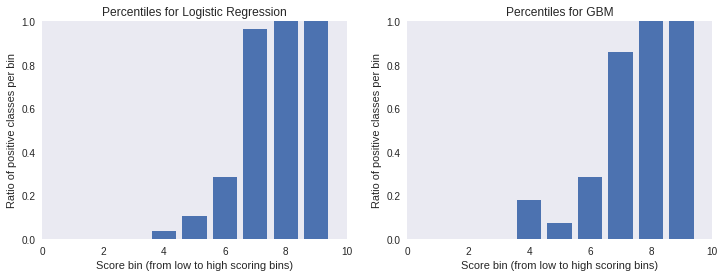

In [40]:
s_titles = ['Logistic Regression', 'GBM']

plt.figure(figsize=(12, 4))
for i, s_clf in enumerate(li_clfs):
    s_title = s_titles[i]
    
    if s_clf == 'clf_lr':
        dfr = dfr_lr 
        dfr2 = dfr2_lr 
    elif s_clf == 'clf_gb':
        dfr = dfr_gb
        dfr2 = dfr2_gb
    else:
        print('Error')
        break
    
    plt.subplot(1, 2, i+1)
    plt.bar(dfr['i_bin'], dfr['pos_rate'])
    plt.title('Percentiles for ' + s_title)

    # Format charts
    plt.grid()
    plt.xlabel('Score bin (from low to high scoring bins)')
    plt.ylabel('Ratio of positive classes per bin')
    plt.legend(loc="lower right")
    
    plt.xlim([0, RANK_BINS])
    plt.ylim([0.0, 1])
    
plt.show()

** Often we prefer models that give consistent results as the score value increases. For this kind of analysis, we prefer models that result in score bins that are monotonically increasing as a function of the ratio of positive classes per bin - as is the case for the Logistic Regression model here.

## Print ROC stats per bin

In [41]:
print("Results of ROC stats per bin")
print("Logistic Regression stats:")
print(dfr2_lr.to_string())
print()
print("GBM stats:")
print(dfr2_gb.to_string())

Results of ROC stats per bin
Logistic Regression stats:
   i_bin   score_min  score_max     tnr     fpr     fnr     tpr     tn     fp     fn     tp
0    0.0  1.4162e-06     0.0002  0.1467  0.8533  0.0000  1.0000   27.0  157.0    0.0  101.0
1    1.0  2.2817e-04     0.0009  0.2989  0.7011  0.0000  1.0000   55.0  129.0    0.0  101.0
2    2.0  8.8079e-04     0.0033  0.4511  0.5489  0.0000  1.0000   83.0  101.0    0.0  101.0
3    3.0  3.4479e-03     0.0113  0.6033  0.3967  0.0000  1.0000  111.0   73.0    0.0  101.0
4    4.0  1.1498e-02     0.0340  0.7500  0.2500  0.0099  0.9901  138.0   46.0    1.0  100.0
5    5.0  3.7364e-02     0.3061  0.8859  0.1141  0.0396  0.9604  163.0   21.0    4.0   97.0
6    6.0  3.1318e-01     0.8655  0.9946  0.0054  0.1188  0.8812  183.0    1.0   12.0   89.0
7    7.0  8.6965e-01     0.9966  1.0000  0.0000  0.3861  0.6139  184.0    0.0   39.0   62.0
8    8.0  9.9779e-01     1.0000  1.0000  0.0000  0.6634  0.3366  184.0    0.0   67.0   34.0
9    9.0  9.9998e-01    

## ROC and Precision-Recall curves

MODEL: clf_lr
--------------


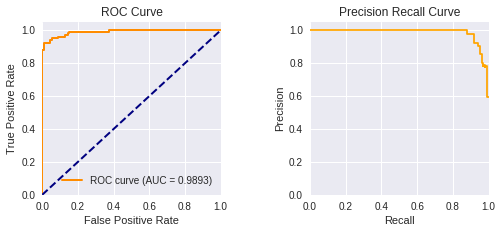


MODEL: clf_gb
--------------


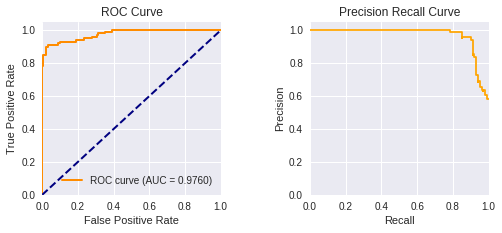

In [42]:
def plot_roc_and_precision_recall(y_true, y_score):
  # Get ROC curve FPR and TPR from true labels vs score values
  fpr, tpr, _ = roc_curve(y_true, y_score)

  # Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
  roc_auc = auc(fpr, tpr)

  # Calculate precision and recall from true labels vs score values
  precision, recall, _ = precision_recall_curve(y_true, y_score)

  plt.figure(figsize=(8, 3))

  plt.subplot(1,2,1)
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  plt.grid(True)

  plt.subplot(1,2,2)
  plt.step(recall, precision, color='orange', where='post')
  # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision Recall Curve')
  plt.grid(True)

  left  = 0.125  # the left side of the subplots of the figure
  right = 0.9    # the right side of the subplots of the figure
  bottom = 0.1   # the bottom of the subplots of the figure
  top = 0.9      # the top of the subplots of the figure
  wspace = 0.5   # the amount of width reserved for blank space between subplots
  hspace = 0.2   # the amount of height reserved for white space between subplots
  plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
  plt.show()

  
for s_clf in li_clfs:
    print("MODEL: " + s_clf)
    print("--------------")
    clf = eval(s_clf)
    
    y_pred = clf.predict(X_test).astype(int)
    y_score = clf.predict_proba(X_test)
    
    plot_roc_and_precision_recall(y_test, y_score[:,1])  # provide the column for the scores belonging only to the positive class
    print()
    

## Summary  

* A correlation technique for feature reduction was demonstrated resulting in a reduced subset of 9 out of the original 30 features.

* Two different model types were demonstrated, Logistic Regression and GBM. Optimal parameters were found using sklearn's GridSearchCV.

* The ranking of the feature importance of the two different models resulted in a slightly different feature importance. Note that if we test many model types, we can then use ensemble techniques in order to improve overall performance.

* Often we prefer models that give consistent results as the score value increases. For this kind of analysis, we prefer models that result in score bins that are monotonically increasing as a function of the ratio of positive classes per bin - as is the case for the Logistic Regression model here.

* The Logistic Regression's ROC AUC (Area Under the Curve) score was a little better than that of the GBM. Note that this result was the outcome of using a relatively small train set (50% of all the data).

* By setting TEST_SIZE_RATIO = 0.2 (which means that the train size ratio is 0.8), we can train on more data and this results in improved ROC AUC metrics for the GBM. Note that the smaller test set will result in a less stable ROC AUC result. To further validate our findings, we could average multiple random train/test splits (either bootstrapped or averaging over independent test data splits).
